In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install utm
!pip -q install rasterio
!pip -q install xmltodict

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.4 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import geopandas as gpd
from glob import glob
import os
import utm
import rasterio
from tqdm import tqdm
import xmltodict
from datetime import datetime, timedelta,date
import zipfile
from rasterio.plot import show
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle as pk
import json
from shapely.geometry import MultiPolygon,shape
from shapely.wkt import loads
import shutil
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import warnings
warnings.filterwarnings('ignore')

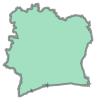

In [ ]:
with open("/content/drive/MyDrive/Biomass_Mapping/data/CIV_0.json","r") as file:
  data = json.load(file)
MultiPolygon(shape(data['features'][0]['geometry']))

In [ ]:
coords = data['features'][0]['geometry']['coordinates'][0][0]+data['features'][0]['geometry']['coordinates'][1][0]+data['features'][0]['geometry']['coordinates'][2][0]

In [ ]:
#features = [data['features'][0]['geometry']['coordinates'][1]+data['features'][0]['geometry']['coordinates'][2]]
features = [data['features'][0]['geometry']['coordinates'][0]]
data['features'][0]['geometry']['coordinates'] = features

In [ ]:
lat_min = min([c[1] for c in coords])
lat_max = max([c[1] for c in coords])
lon_min = min([c[0] for c in coords])
lon_max = max([c[0] for c in coords])
##
lats = np.arange(lat_min,lat_max,.05)
lons = lat = np.arange(lon_min,lon_max,.05)
##
len(lats)*len(lons)

15744

In [ ]:
# select ivory coast points
ivoire_cordinate = []
polygon = Polygon(coords)
for lat in lats:
  for lon in lons:
    p = [lon,lat]
    point = Point(p)
    if polygon.contains(point):
        ivoire_cordinate.append(p)
len(ivoire_cordinate)

10606

# Modeling

In [ ]:
##
def unzip(path):
    #file_path = os.path.join(path,"*.zip")
    files = glob(path)
    for file in files:
         with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall()


##
def select_best_cloud_coverage_tile():
    tile_names = {}
    cld_prob = []
    folders = glob('*.SAFE')
    for fold in folders:
        metadata_path = fold+"/MTD_MSIL2A.xml"
        xml_file=open(metadata_path,"r")
        xml_string=xml_file.read()
        python_dict=xmltodict.parse(xml_string)
        cld = float(python_dict["n1:Level-2A_User_Product"]["n1:Quality_Indicators_Info"]["Cloud_Coverage_Assessment"])
        tile_names[cld] = fold
        cld_prob.append(cld)
    name = tile_names[min(cld_prob)]
    dates = name.split('_')[2][:8]
    acquisition_date = datetime.strptime(dates, "%Y%m%d")
    today = datetime.now()
    delta = (today - acquisition_date)
    days_ago = delta.days
    return name,min(cld_prob),days_ago

##
def find_good_tile(df, point):
    for row in tqdm(df.itertuples(),total=len(df)):
        tile_name = row.tiles
        coordinate = row.coords
        x = coordinate.replace(']','')
        x = x.replace('[','')
        x = x.replace("'",'')
        tab = [[float(x.split(",")[i]),float(x.split(",")[i+1])] for i in range(0,len(x.split(",")),2)]
        polygon = Polygon(tab)
        result  = polygon.contains(point)
        if result:
            print(tile_name)
            return tile_name

    return 404

##
def delete_tiles():
        files = glob('*.zip')
        folders1 = glob('*.SAFE')
        folders2 = glob("*.tmp")
        for f in files:
            os.remove(f)
        for fold in folders1:
            shutil.rmtree(fold, ignore_errors=True)

        for fold in folders2:
            shutil.rmtree(fold, ignore_errors=True)

In [ ]:
##
def cloud_masking(image,cld):
        cloud_mask = cld > 30
        band_mean = image.mean()
        image[cloud_mask] = band_mean
        return image

##
def load_file(fp):
    """Takes a PosixPath object or string filepath
    and returns np array"""

    return np.array(Image.open(fp.__str__()))

def paths (name):

    fold_band_10 = glob(name+"/GRANULE/*/IMG_DATA/R10m")[0]
    fold_band_20 = glob(name+"/GRANULE/*/IMG_DATA/R20m")[0]
    fold_band_60 = glob(name+"/GRANULE/*/IMG_DATA/R60m")[0]
    path = name+"/GRANULE/*/IMG_DATA/R10m"+"/*.jp2"
    x = glob(path)
    lists = x[0].split("/")[-1].split("_")
    fixe = lists[0]+'_'+lists[1]

    band_10 = ['B02', 'B03', 'B04','B08']
    band_20 = ['B05', 'B06', 'B07','B8A','B11', 'B12']
    band_60 = ['B01','B09']
    images_name_10m = [fixe+"_"+band+"_10m.jp2" for band in band_10 ]
    images_name_20m = [fixe+"_"+band+"_20m.jp2" for band in band_20 ]
    images_name_60m = [fixe+"_"+band+"_60m.jp2" for band in band_60 ]
    #
    bandes_path_10 = [os.path.join(fold_band_10,img) for img in images_name_10m]
    bandes_path_20 = [os.path.join(fold_band_20,img) for img in images_name_20m]
    bandes_path_60 = [os.path.join(fold_band_60,img) for img in images_name_60m]
    #
    tile_path = name+"/INSPIRE.xml"
    path_cld_20 = glob(name+"/GRANULE/*/QI_DATA/MSK_CLDPRB_20m.jp2")[0]
    path_cld_60 = glob(name+"/GRANULE/*/QI_DATA/MSK_CLDPRB_60m.jp2")[0]

    return bandes_path_10,bandes_path_20,bandes_path_60,tile_path,path_cld_20,path_cld_60

##
def coords_to_pixels(ref, utm, m=10):
    """ Convert UTM coordinates to pixel coordinates"""

    x = int((utm[0] - ref[0])/m)
    y = int((ref[1] - utm[1])/m)

    return x, y

##
def extract_sub_image(images,bandes_path,tile_path,area,resolution=10, d= 3,cld_path = None,*args):

  xml_file=open(tile_path,"r")
  xml_string=xml_file.read()
  python_dict=xmltodict.parse(xml_string)
  tile_coordonnates = python_dict["gmd:MD_Metadata"]["gmd:identificationInfo"]["gmd:MD_DataIdentification"]["gmd:abstract"]["gco:CharacterString"].split()

  # S2 tile coordonnates
  lat,lon = float(tile_coordonnates[0]),float(tile_coordonnates[1])
  tile_coordonnate = [lat,lon]
  #print("========tile_coordonnate",tile_coordonnate)

  refx, refy, _, _ = utm.from_latlon(tile_coordonnate[0], tile_coordonnate[1])
  ax,ay,_,_ = utm.from_latlon(area[1],area[0]) # lat,lon

  ref = [refx, refy]
  utm_cord = [ax,ay]
  x,y = coords_to_pixels(ref,utm_cord,resolution)
  #print(f"X====={x},Y======{y}")

  # sub_image_extraction
  for image in args:
    #image = load_file(band_path).astype(np.float32)
    #print("IMAGE DIMENSION===-------------",image.shape)
    if resolution==60:
        sub_image = image[y,x]
        images.append(sub_image)
        #del image
        del sub_image

    else:
        sub_image = image[y-d:y+d,x-d:x+d]
        images.append(sub_image)
        #del image
        del sub_image

  images = np.array(images)


 # verify if the study are is cloudy
  if cld_path is not None:
    cld_mask = load_file(cld_path).astype(np.float32)
    cld = cld_mask[y-d:y+d,x-d:x+d]
    # cloud removing
    images = cloud_masking(images,cld)

  if resolution==60:
      return images
  else:
      return images.mean((1,2))


def ndvi(area, tile_name):
    """
    polygone: (lon,lat) format
    tile_name: name of tile with the most low cloud coverage
    """
    #Extract tile  coordonnates (lat,long)
    tile_path = tile_name+"/INSPIRE.xml"
    xml_file=open(tile_path,"r")
    xml_string=xml_file.read()
    python_dict=xmltodict.parse(xml_string)
    tile_coordonnates = python_dict["gmd:MD_Metadata"]["gmd:identificationInfo"]["gmd:MD_DataIdentification"]["gmd:abstract"]["gco:CharacterString"].split()

    # S2 tile coordonnates
    lat,lon = float(tile_coordonnates[0]),float(tile_coordonnates[1])
    tile_coordonnate = [lat,lon]

    refx, refy, _, _ = utm.from_latlon(tile_coordonnate[0], tile_coordonnate[1])
    ax,ay,_,_ = utm.from_latlon(area[1],area[0]) # lat,lon

    ref = [refx, refy]
    utm_cord = [ax,ay]
    x,y = coords_to_pixels(ref,utm_cord)

    # read images
    path_4 = tile_name+"/GRANULE/*/IMG_DATA/R10m/*_B04_10m.jp2"
    path_8 = tile_name+"/GRANULE/*/IMG_DATA/R10m/*_B08_10m.jp2"
    red_object = rasterio.open(glob(path_4)[0])
    nir_object = rasterio.open(glob(path_8)[0])
    red = red_object.read()
    nir = nir_object.read()
    red,nir = red[0],nir[0]
    # extract area and remove unsigne
    sub_red = red[y-3:y+3,x-3:x+3].astype(np.float16)
    sub_nir = nir[y-3:y+3,x-3:x+3].astype(np.float16)

    # NDVI
    ndvi_image = ((sub_nir - sub_red)/(sub_nir+sub_red))
    ndvi_mean_value = ndvi_image.mean()

    return ndvi_mean_value


In [ ]:
def indices(X):
    # Calculate vegetation indices
    #S2REP
    #OTHERS

    X["AWEInsh"] = 4.0*(X["B03"]-X["B11"])-0.25*X["B08"]+2.75*X["B12"]

    X["NBSIMS"] = 0.36*(X["B03"]+X["B04"]+X["B08"]) - (((X["B02"]+X["B12"])/X["B03"])+X["B11"])

    X["MuWIR"] = -4.0*((X["B02"]-X["B03"])/(X["B02"]+X["B03"]))+2.0*((X["B03"]-X["B08"])/(X["B03"]+X["B08"]))+2.0*((X["B03"]-X["B12"])/(X["B03"]+X["B12"]))-((X["B03"]-X["B11"])/(X["B03"]+X["B11"]))

    X["VARI700"] = (X["B05"]-1.7*X["B04"]+0.7*X["B02"])/(X["B05"]+1.3*X["B04"]-1.3*X["B02"])

    X["S2WI"] = (X["B05"]-X["B12"])/(X["B05"]+X["B12"])

    X["NBAI"] = ((X["B12"]-X["B11"])/X["B03"])/((X["B12"]+X["B11"])/X["B03"])

    X["TCARI"] = 3*((X["B05"]-X["B04"]))-0.2*(X["B05"]-X["B03"])*(X["B05"]/X["B04"])

    X["WI2015"] = 1.7204+171*X["B03"]+3*X["B04"]-70*X["B08"]-45*X["B11"]-71*X["B12"]

    X["BAIM"] = 1.0/((0.05-X["B08"])**2.0)+((0.2-X["B12"])**2.0)

    X["NDDI"] = (( (X["B08"]-X["B04"])/(X["B08"]+X["B04"])-((X["B03"]-X["B08"])/(X["B03"]+X["B08"])))/((X["B08"]-X["B04"])/(X["B08"]+X["B04"]))+((X["B03"]-X["B08"])/(X["B03"]+X["B08"])))

    X["BCC"] = X["B02"]/(X["B04"]+X["B03"]+X["B02"])

    X["RCC"] = X["B04"]/(X["B04"]+X["B03"]+X["B02"])

    X["IKAW"] = (X["B08"]-X["B02"])/(X["B08"]+X["B02"])

    X["ARI"] = (1/X["B03"])-(1/X["B05"])

    X["MIRBI"] = 10.0*X["B12"]-9.8*X["B11"]+2.0

    X["NMDI2"] = (X["B08"]-(X["B11"]-X["B12"]))/(X["B08"]+(X["B11"]-X["B12"]))

    X["TTVI"] = 0.5*((865.0-740.0)*(X["B8A"]-X["B06"]-(X["B07"]-X["B06"])*(783.0-740)))

    X["NHFD"] = (X["B05"]-X["B01"])/(X["B05"]+X["B01"])

    X["NDSWIR"] = (X["B11"]-X["B8A"])/(X["B11"]+X["B8A"])

    X["NBRSWIR"] = (X["B12"]-X["B11"]-0.02)/(X["B12"]+X["B11"]+0.1)

    X["NBR"] = (X["B12"]-X["B8A"])/(X["B12"]+X["B8A"])

    X["NBRplus"] = (X["B12"]-X["B8A"]-X["B03"]-X["B02"])/(X["B12"]+X["B8A"]+X["B03"]+X["B02"])

    X["NDWI2"] = (X["B02"]-X["B08"])/(X["B02"]+X["B08"])

    X["NDWI1"] = (X["B01"]-X["B08"])/(X["B01"]+X["B08"])

    X["S2REP"] = 705 + 35 * ((((X["B07"] + X["B04"])/2) - X["B05"])/(X["B06"] - X["B05"]))

    X["CCCI"] = ((X["B08"] - X["B05"]) / (X["B08"] + X["B05"])) / ((X["B08"] - X["B04"]) / (X["B08"] + X["B04"]))

    X["MCARI"] = ((X["B05"] - X["B04"]) - 2 * (X["B05"] - X["B03"])) * (X["B05"] / X["B04"])

    X["TCARI"] = 3 * ((X["B05"] - X["B04"]) - 0.2 * (X["B05"] - X["B03"]) * (X["B05"] / X["B04"]))

    X["PVI"] = (X["B08"] - 0.3 * X["B04"] - 0.5) / ((1 + 0.3 * 2) ** (1/2.0))

    X["NDVI"] = (X["B08"] - X["B04"]) / (X["B08"] + X["B04"])

    X["EVI"] = 2.5 * (X["B08"] - X["B04"]) / (X["B08"] + 6 * X["B04"] - 7.5 * X["B02"] + 1)

    X["SAVI"] = (X["B08"] - X["B04"]) / (X["B08"] + X["B04"] + 0.5)

    X["MNDWI"] = (X["B03"] - X["B08"]) / (X["B03"] + X["B08"])

    X["ARVI"] = (X["B08"] - (2 * X["B04"]) + X["B02"]) / (X["B08"] + (2 * X["B04"]) + X["B02"])

    X["SIPI"] = (X["B08"] - X["B02"]) / (X["B08"] - X["B04"])

    X["RENDVI"] = (X["B06"] - X["B05"]) / (X["B06"] + X["B05"])

    X["MRESR"] = (X["B06"] - X["B01"]) / (X["B05"] - X["B01"])

    # CANOLA
    X["RYI"] = X["B03"] / X["B02"]

    X["NDYI"] = (X["B03"] - X["B02"]) / (X["B03"] + X["B02"])

    X["DYI"] = X["B03"] - X["B02"]

    X["ACI"] = X["B08"] * (X["B04"] + X["B03"])

    # WEED
    X["CVI"] = (X["B08"] / X["B03"]) * (X["B04"] / X["B03"])

    X["AVI"] = (X["B08"] * (1 - X["B04"]) * (X["B08"] - X["B04"]))

    X["SI"] = ((1 - X["B02"]) * (1 - X["B03"]) * (1 - X["B04"]))

    X["BSI"] = ((X["B11"] + X["B04"]) - (X["B08"] + X["B02"])) / ((X["B11"] + X["B04"]) + (X["B08"] + X["B02"]))

    # WINE GRAPES
    X["MTCI"] = (X["B06"] - X["B05"])/(X["B05"] - X["B04"])

    X["NPCRI"] = (X["B04"] - X["B02"]) / (X["B04"] + X["B02"])

    # ROOIBOS
    X["BAI"] = 1/((0.1 - X["B04"]) ** 2 + (0.06 - X["B08"]) ** 2)

    MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(X["B08"], X["B03"], X["B04"]))
    X["MTVI2"] = np.array(MTVI2)

    X["NDSI"] = (X["B03"] - X["B11"]) / (X["B03"] + X["B11"])

    # DRYNESS / DROUGHT
    X["NDMI"] = (X["B08"] - X["B11"])/(X["B08"] + X["B11"])

    TNDVI = [(x)**(1/2.0) for x in ((X["B08"] - X["B04"]) / (X["B08"] + X["B04"]) + 0.5)]
    X["TNDVI"] = np.array(TNDVI)

    # GENERAL
    X["TVI"] = (120 * (X["B06"] - X["B03"]) - 200 * (X["B04"] - X["B03"])) / 2

    X["EXG"] = 2 * X["B03"] - X["B04"] - X["B02"]

    X["PSRI"] = (X["B04"] - X["B02"]) / X["B06"]

    return X

In [ ]:
d = glob('*.SAFE')
len(d)

1

In [ ]:
for i in d :
#fold ="/content/S2A_MSIL2A_20231211T105431_N0509_R051_T29PPL_20231211T153351.SAFE"
 shutil.rmtree(i, ignore_errors=True)

In [ ]:
path1 = '/content/drive/MyDrive/Biomass_Mapping/No_values_bands/S2A_MSIL2A_20230102T104441_N0509_R008_T29NPJ_20230102T173659.SAFE.zip'
unzip(path1)

In [ ]:
tile_path ="/content/S2A_MSIL2A_20230102T104441_N0509_R008_T29NPJ_20230102T173659.SAFE/INSPIRE.xml"
xml_file=open(tile_path,"r")
xml_string=xml_file.read()
python_dict=xmltodict.parse(xml_string)
tile_coordonnates = python_dict["gmd:MD_Metadata"]["gmd:identificationInfo"]["gmd:MD_DataIdentification"]["gmd:abstract"]["gco:CharacterString"].split()
coords = [[float(tile_coordonnates[i]),float(tile_coordonnates[i+1])] for i in range(0,len(tile_coordonnates),2)]

In [ ]:
df = pd.DataFrame(columns=["Latitude","Longitude","Biomass","identifiant"])
poly = Polygon(coords) # tile cordinate

name,cld_prob,days_ago = select_best_cloud_coverage_tile()
bandes_path_10,bandes_path_20,bandes_path_60,tile_path,path_cld_20,path_cld_60 = paths(name)

In [ ]:
folder10 = '/content/S2A_MSIL2A_20230102T104441_N0509_R008_T29NPJ_20230102T173659.SAFE/GRANULE/L2A_T29NPJ_A039330_20230102T105319/IMG_DATA/R10m'
folder20 = '/content/S2A_MSIL2A_20230102T104441_N0509_R008_T29NPJ_20230102T173659.SAFE/GRANULE/L2A_T29NPJ_A039330_20230102T105319/IMG_DATA/R20m'
folder60 = '/content/S2A_MSIL2A_20230102T104441_N0509_R008_T29NPJ_20230102T173659.SAFE/GRANULE/L2A_T29NPJ_A039330_20230102T105319/IMG_DATA/R60m'

raster_files10=[]
raster_files20=[]
raster_files60=[]

bands10 = ['B02', 'B03', 'B04', 'B08']
bands20 = ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12']
bands60 = ['B01', 'B09']

for k in bands10:
    raster_files10.extend(glob(os.path.join(folder10, f'*_{k}_10m.jp2')))

for m in bands20:
    raster_files20.extend(glob(os.path.join(folder20, f'*_{m}_20m.jp2')))

for n in bands60:
    raster_files60.extend(glob(os.path.join(folder60, f'*_{n}_60m.jp2')))

files1 = raster_files10 + raster_files20 + raster_files60

In [ ]:
path2 = '/content/drive/MyDrive/Biomass_Mapping/No_values_bands/S2B_MSIL2A_20221231T105349_N0509_R051_T29NPJ_20221231T133126.SAFE.zip'
unzip(path2)

In [ ]:
folder10m = '/content/S2B_MSIL2A_20221231T105349_N0509_R051_T29NPJ_20221231T133126.SAFE/GRANULE/L2A_T29NPJ_A030393_20221231T110338/IMG_DATA/R10m'
folder20m = '/content/S2B_MSIL2A_20221231T105349_N0509_R051_T29NPJ_20221231T133126.SAFE/GRANULE/L2A_T29NPJ_A030393_20221231T110338/IMG_DATA/R20m'
folder60m = '/content/S2B_MSIL2A_20221231T105349_N0509_R051_T29NPJ_20221231T133126.SAFE/GRANULE/L2A_T29NPJ_A030393_20221231T110338/IMG_DATA/R60m'

raster_file10 = []
raster_file20 = []
raster_file60 = []

for k in bands10:
    raster_file10.extend(glob(os.path.join(folder10m, f'*_{k}_10m.jp2')))

for m in bands20:
    raster_file20.extend(glob(os.path.join(folder20m, f'*_{m}_20m.jp2')))

for n in bands60:
    raster_file60.extend(glob(os.path.join(folder60m, f'*_{n}_60m.jp2')))

files2 = raster_file10 + raster_file20 + raster_file60

In [ ]:
from rasterio.merge import merge
mosaic_bands = []
for band_path1, band_path2 in zip(files1, files2):
    scenes = [band_path1, band_path2]
    src_files_to_mosaic = [rasterio.open(fp) for fp in scenes]
    mosaic, out_trans = merge(src_files_to_mosaic)
    mosaic = mosaic[0]
    mosaic_bands.append(mosaic)

In [ ]:
# later reload the pickle file
sdc_reload = pk.load(open("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/sdc_mt.pkl",'rb'))
pca_reload = pk.load(open("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/pca_mt.pkl",'rb'))
#X_reload = pk.load(open("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/X_sdc_mt.pkl","rb"))
tsne_reload = pk.load(open("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/tsne_mt.pkl",'rb'))

# load the model from disk
filename = "/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/tsne_mean_48.sav"
loaded_model = pk.load(open(filename, 'rb'))

for i,c in enumerate(tqdm(ivoire_cordinate,total=len(ivoire_cordinate))):
    p = [c[1],c[0]]
    point = Point(p)
    if poly.contains(point):
        print("=========Polygon ",poly)
        print("=========== Point",c)

        # create image dataset
        images = []
        images_10 = extract_sub_image(images,bandes_path_10,tile_path,c,10,3,None,mosaic_bands[0],mosaic_bands[1],mosaic_bands[2],mosaic_bands[3])
        #print(images_10)

        # bandes with 20m resolution
        #path_cld_20
        images = []
        images_20 = extract_sub_image(images,bandes_path_20,tile_path,c,20,1,None,mosaic_bands[4],mosaic_bands[5],mosaic_bands[6],mosaic_bands[7],mosaic_bands[8],mosaic_bands[9])
        #print(images_20)

        # bandes with 60m resolution
        #path_cld_60
        images = []
        images_60 = extract_sub_image(images,bandes_path_60,tile_path,c,60,1,None,mosaic_bands[10],mosaic_bands[11])
        #print(images_60)
        #
        feature = images_10.tolist()+images_20.tolist()+images_60.tolist()
        print("Feature=====",feature)
        bands = ['B02', 'B03', 'B04', 'B08', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12','B01','B09']
        X = pd.DataFrame([feature],columns = bands)

        X = X[['B02', 'B03', 'B04', 'B08', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12','B01','B09']]
        ## Coordinate
        cord_df = pd.DataFrame({"Latitude":[c[1]], "Longitude":[c[0]]}) # extract lat,lon
        del images
        del images_10
        del images_20
        del images_60
        del feature

        # standardization
        X_pca = sdc_reload.transform(X)
        # make pca
        principalComponents = pca_reload .transform(X_pca)
        principalDf = pd.DataFrame(data =principalComponents[:,:4],
                        columns = ["PC1","PC2","PC3","PC4"])

        dat2 = pd.read_csv("/content/drive/MyDrive/Biomass_Mapping/Results/X_data.csv", index_col=0)
        dat2 = dat2[:15]
        dataset_mean = pd.concat([dat2, X], ignore_index=True)
        scaled_mean = sdc_reload.transform(dataset_mean)
        tsne_data_mean = tsne_reload.fit_transform(scaled_mean)
        tsne_data_mean = tsne_data_mean[-1]
        tsne_data_mean = tsne_data_mean.reshape(1, -1)
        tsne_mean = pd.DataFrame(data=tsne_data_mean, columns=[f"TC{i+1}" for i in range(5)])

        # vegetation index calculation
        X = indices(X)

        # Drop all 12 bands of S2
        tab = list(range(12))
        X_index = X.drop(X.iloc[:,tab],axis=1)

       # column = X_index.columns
        #X_index_mean = X_reload.fit_transform(X_index)

        #X_index = pd.DataFrame(X_index_mean, columns=column)

        # Create predictive features
        #X_final =pd.concat([cord_df,principalDf,X_index],axis=1)
        X_final =pd.concat([cord_df,tsne_mean,X_index],axis=1)
        #X_final =pd.concat([cord_df,principalDf,tsne_mean,X_index],axis=1)

        # make prediction
        biomass = int(loaded_model.predict(X_final)[0])
        #print("================",biomass)
        del X
        del X_index
        del X_final
        del principalComponents
        del principalDf
        del X_pca

        if biomass<0:
                biomass =0
    else :
        biomass =None

    #print(biomass)
    id = "zone_"+str(i)
    X = pd.DataFrame({"Latitude":[c[1]],
                      "Longitude":[c[0]],
                      "Biomass":[biomass],
                      "identifiant":[id]
                      })

    df = pd.concat([df,X])
    df = df.reset_index(drop=True)
    #break

In [ ]:
def test(x):
  if x==None:
    return -1
  else:
     return x

df["Biomass"] = df.apply(lambda x:test(x["Biomass"]),axis=1)

In [ ]:
np.unique(df["Biomass"],return_counts=True)

(array([ -1,  33,  37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 158,
        160, 161, 162, 163, 164, 166, 168, 169, 170, 171, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 190,
        191, 197, 198, 199, 201, 202, 203, 204, 206, 208, 209, 214, 215,
        217, 220, 222, 229, 240]),
 array([10212,     1,     1,     1,     1,     2,     1,     3,     3,
            3,    

In [ ]:
#df = pd.reas_csv("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/data_last.csv")
df = df[["identifiant","Biomass"]]
df2 = pd.read_csv("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/maps_predict.csv")
print(df2.shape)
df_final = df2.merge(df, on ="identifiant",how="left")
display(df_final.head(),df_final.shape)

(9568656, 4)


,identifiant,Latitude,Longitude,Biomass_x,Biomass_y
0,zone_0,4.4118,-7.5493,68,-1
1,zone_0,4.4118,-7.5493,68,-1
2,zone_0,4.4118,-7.5493,68,-1
3,zone_0,4.4118,-7.5493,68,-1
4,zone_0,4.4118,-7.5493,68,-1


(9568656, 5)

In [ ]:
def good_biomass(x,y):
  if x==-1 and y==-1:
    return -1
  elif y==-1:
    return x
  else:
    return y

df_final["Biomass"] = df_final.apply(lambda x:good_biomass(x["Biomass_x"],x["Biomass_y"]),axis=1)
df = df_final[["identifiant","Latitude","Longitude","Biomass"]]

In [ ]:
def good_biomass(x,y):
  if x==-1 and y==-1:
    return -1
  elif x==-1:
    return y
  else:
    return x

df_final["Biomass"] = df_final.apply(lambda x:good_biomass(x["Biomass_x"],x["Biomass_y"]),axis=1 )
df = df_final[["identifiant","Latitude","Longitude","Biomass"]]

In [ ]:
np.unique(df["Biomass"],return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [ ]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df,  crs = crs, geometry = geometry)
geo_df.head()

,identifiant,Latitude,Longitude,Biomass,geometry
0,zone_0,4.4118,-7.5493,68,POINT (-7.54930 4.41180)
1,zone_0,4.4118,-7.5493,68,POINT (-7.54930 4.41180)
2,zone_0,4.4118,-7.5493,68,POINT (-7.54930 4.41180)
3,zone_0,4.4118,-7.5493,68,POINT (-7.54930 4.41180)
4,zone_0,4.4118,-7.5493,68,POINT (-7.54930 4.41180)


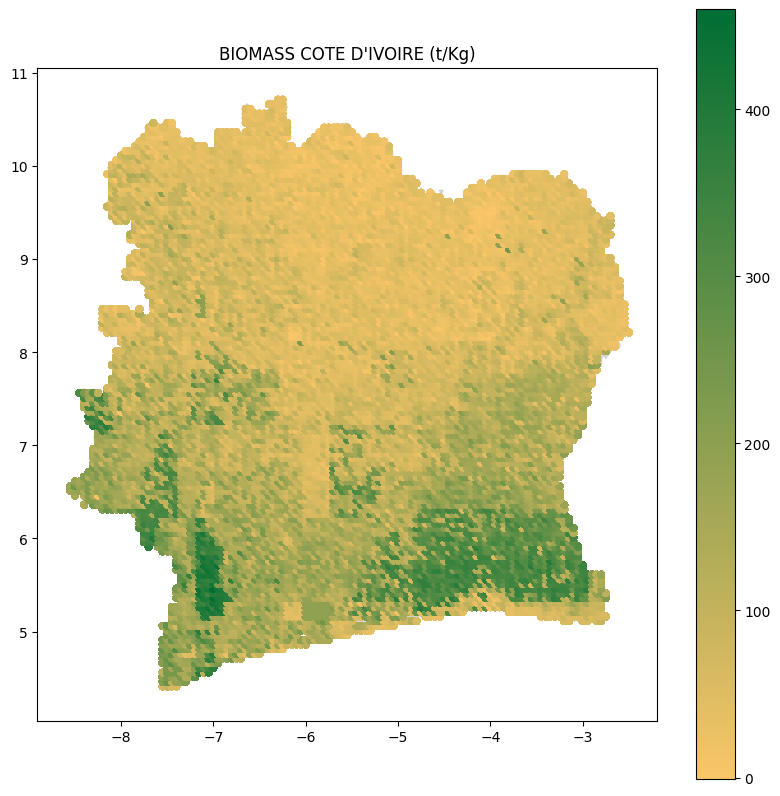

In [ ]:
path = "/content/drive/MyDrive/Biomass_Mapping/shape_ci/CIV_adm1.shp"
kings_county_map = gpd.read_file(path)
#kings_county_map.plot()

#geo_df['Biomass_log'] = np.log(geo_df['Biomass'])
fig, ax = plt.subplots(figsize = (10,10))
kings_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)] # ndvi colors
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=1100)
geo_df.plot(column = 'Biomass', ax=ax, cmap =cmap ,
            legend = True, legend_kwds={'fmt': 0.3},
            markersize = 20)
ax.set_title("BIOMASS COTE D'IVOIRE (t/Kg)") #'rainbow'
plt.savefig('Biomass_Map_new2')

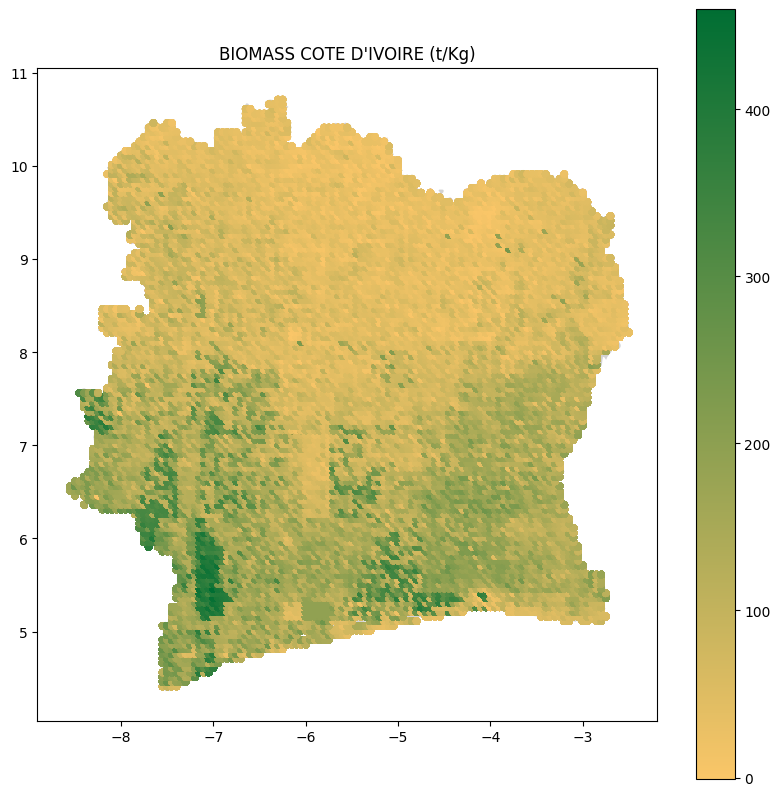

In [ ]:
path = "/content/drive/MyDrive/Biomass_Mapping/shape_ci/CIV_adm1.shp"
kings_county_map = gpd.read_file(path)
#kings_county_map.plot()

#geo_df['Biomass_log'] = np.log(geo_df['Biomass'])
fig, ax = plt.subplots(figsize = (10,10))
kings_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)] # ndvi colors
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=1100)
geo_df.plot(column = 'Biomass', ax=ax, cmap =cmap ,
            legend = True, legend_kwds={'fmt': 0.3},
            markersize = 20)
ax.set_title("BIOMASS COTE D'IVOIRE (t/Kg)") #'rainbow'
plt.savefig('Biomass_Map_new')

In [ ]:
df.to_csv("/content/drive/MyDrive/Biomass_Mapping/Karim_weigths/maps_predict.csv",index=False)

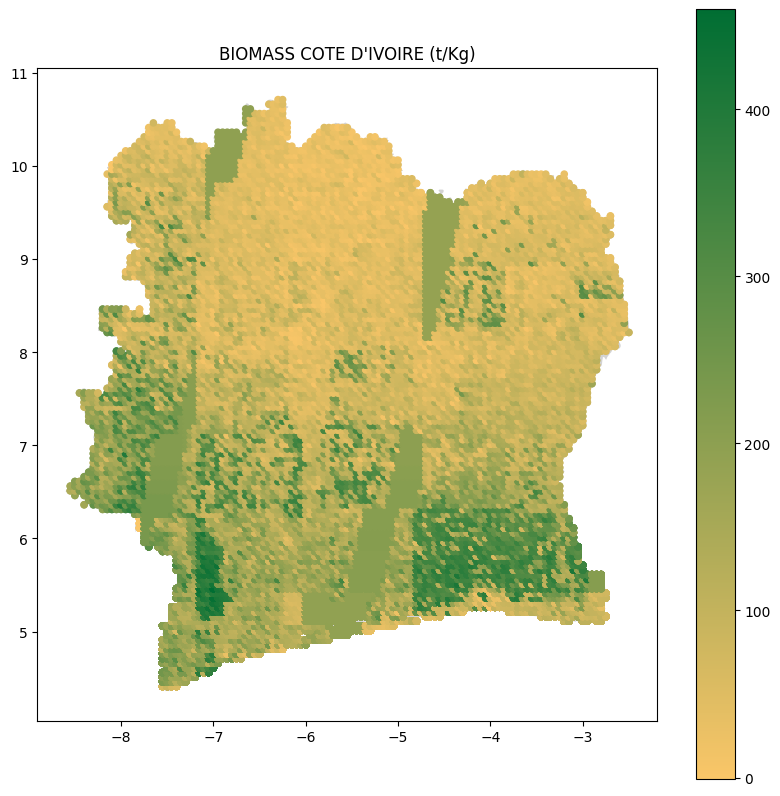

In [ ]:
path = "/content/drive/MyDrive/Biomass_Mapping/shape_ci/CIV_adm1.shp"
kings_county_map = gpd.read_file(path)
#kings_county_map.plot()

#geo_df['Biomass_log'] = np.log(geo_df['Biomass'])
fig, ax = plt.subplots(figsize = (10,10))
kings_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)] # ndvi colors
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=1100)
geo_df.plot(column = 'Biomass', ax=ax, cmap =cmap ,
            legend = True, legend_kwds={'fmt': 0.3},
            markersize = 20)
ax.set_title("BIOMASS COTE D'IVOIRE (t/Kg)") #'rainbow'
plt.savefig('Biomass_Map_new')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

kings_county_map = kings_county_map.to_crs(epsg=4326)

# Create a custom color scale
colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)]
cmap = [[0, 'rgb(250,198,104)'], [1, 'rgb(0,110,51)']]

# Set default to use orca for exporting
pio.orca.config.use_xvfb = True

# Create a Plotly figure
fig = go.Figure()

fig.add_trace(go.Choroplethmapbox(
    geojson=kings_county_map.__geo_interface__,
    locations=[i for i in range(len(kings_county_map))],
    z=[0]*len(kings_county_map),
    colorscale='Greys',
    showscale=False,
    marker_opacity=0.5
))

fig.add_trace(go.Scattermapbox(
    lat=geo_df.geometry.y,
    lon=geo_df.geometry.x,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=8,
        color=geo_df['Biomass'],
        colorscale=cmap,
        colorbar=dict(tickformat='.f'),
        cmin=geo_df['Biomass'].min(),
        cmax=geo_df['Biomass'].max()
    ),
    text=geo_df['Biomass'],
    hoverinfo='text'))

fig.update_layout(
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=geo_df.geometry.y.mean(), lon=geo_df.geometry.x.mean()),
        zoom=6
    ),
    title='BIOMASS COTE D\'IVOIRE (t/Kg)',
    height=800,
    width=800)

fig.show()
# Save the figure as a html file
pio.write_html(fig, file='Biomass_map.html', auto_open=True)

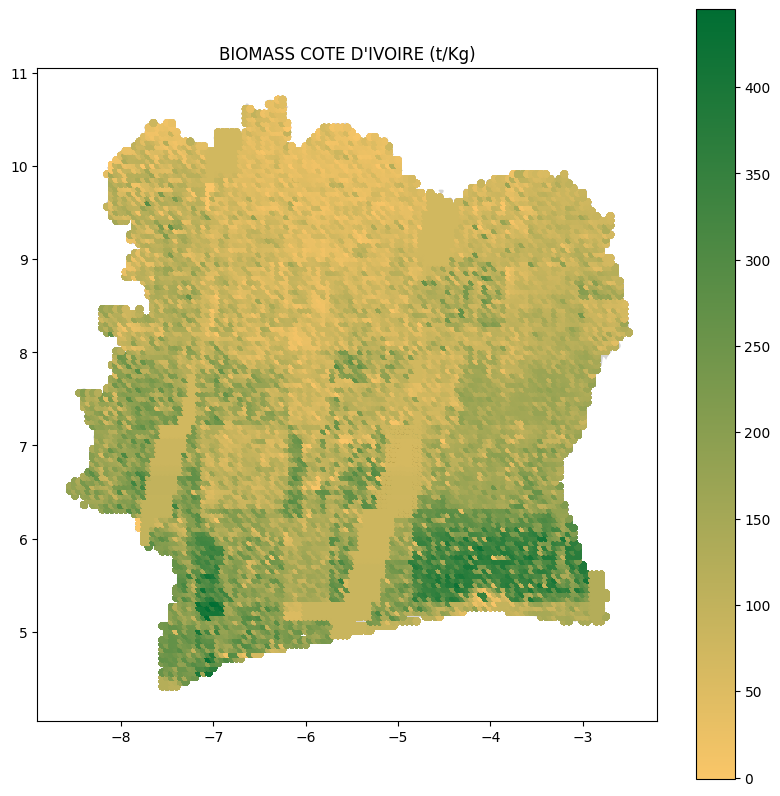

In [ ]:
path = "/content/drive/MyDrive/Biomass_Mapping/shape_ci/CIV_adm1.shp"
kings_county_map = gpd.read_file(path)
#kings_county_map.plot()

#geo_df['Biomass_log'] = np.log(geo_df['Biomass'])
fig, ax = plt.subplots(figsize = (10,10))
kings_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)] # ndvi colors
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=1100)
geo_df.plot(column = 'Biomass', ax=ax, cmap =cmap ,
            legend = True, legend_kwds={'fmt': 0.3},
            markersize = 20)
ax.set_title("BIOMASS COTE D'IVOIRE (t/Kg)") #'rainbow'
plt.savefig('Biomass_map')

In [ ]:
d = glob('*.SAFE')
len(d)

1

In [ ]:
for i in d :
#fold ="/content/S2A_MSIL2A_20231211T105431_N0509_R051_T29PPL_20231211T153351.SAFE"
 shutil.rmtree(i, ignore_errors=True)

In [ ]:
def display_static_map(gdf):

    data = gdf
    # Define the colormap
    colors = [(250/255,198/255,104/255), (0/255,110/255,51/255)] # ndvi colors
    cmap = LinearSegmentedColormap.from_list("Custom", colors, N=20)
    #cmap = plt.get_cmap("winter")

    # Plot the data with colormap based on 'Biomass' values
    fig, ax = plt.subplots(figsize=(10,10))
    data.plot(column='Biomass', cmap=cmap,legend=False, ax=ax) #color=data['color']
    #plt.colorbar()

    # Add labels
    for idx, row in data.iterrows():
        plt.text(row['Longitude'], row['Latitude'],"i",ha='center') #ha='center'

    # Add title
    plt.title('Biomass Predictions in Abidjan, Cote d\'Ivoire')


    # Remove axis
    plt.axis('off')

    # Save the plot
    plt.savefig('predictions.png', bbox_inches='tight')

    # Show the plot
    plt.show()